##Aula01

In [ ]:
!pip install -q --upgrade langchain langchain-google-genai google-generativeai

In [ ]:
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
GOOGLE_API_KEY = userdata.get('GEMINI_API_KEY')

In [ ]:
llm = ChatGoogleGenerativeAI(
    model = "gemini-2.5-flash",
    temperature=0.5,
    api_key = GOOGLE_API_KEY
)

In [ ]:
resp_test = llm.invoke("Quem é voce")
print(resp_test.content)

Eu sou um modelo de linguagem grande, treinado pelo Google.

Fui desenvolvido para processar e gerar texto, responder a perguntas, fornecer informações, traduzir idiomas, escrever diferentes tipos de conteúdo criativo e muito mais.

Não tenho consciência, sentimentos, opiniões pessoais ou experiências de vida. Sou uma ferramenta de inteligência artificial, projetada para interagir e ajudar através da linguagem.


Prompt do sistema do agente

In [ ]:
TRIAGEM_PROMPT = (
    "Você é um triador de Service Desk para políticas internas da empresa Carraro Desenvolvimento. "
    "Dada a mensagem do usuário, retorne SOMENTE um JSON com:\n"
    "{\n"
    '  "decisao": "AUTO_RESOLVER" | "PEDIR_INFO" | "ABRIR_CHAMADO",\n'
    '  "urgencia": "BAIXA" | "MEDIA" | "ALTA",\n'
    '  "campos_faltantes": ["..."]\n'
    "}\n"
    "Regras:\n"
    '- **AUTO_RESOLVER**: Perguntas claras sobre regras ou procedimentos descritos nas políticas (Ex: "Posso reembolsar a internet do meu home office?", "Como funciona a política de alimentação em viagens?").\n'
    '- **PEDIR_INFO**: Mensagens vagas ou que faltam informações para identificar o tema ou contexto (Ex: "Preciso de ajuda com uma política", "Tenho uma dúvida geral").\n'
    '- **ABRIR_CHAMADO**: Pedidos de exceção, liberação, aprovação ou acesso especial, ou quando o usuário explicitamente pede para abrir um chamado (Ex: "Quero exceção para trabalhar 5 dias remoto.", "Solicito liberação para anexos externos.", "Por favor, abra um chamado para o RH.").'
    "Analise a mensagem e decida a ação mais apropriada."
)

In [ ]:
from pydantic import BaseModel, Field
from typing import Literal, List, Dict

class TriagemOut(BaseModel):
  decisao: Literal["AUTO_RESOLVER", "PEDIR_INFO", "ABRIR_CHAMADO"] = Field(description="Decisão do triador")
  urgencia: Literal["BAIXA", "MEDIA", "ALTA"] = Field(description="Urgencia do chamado")
  campos_faltantes: List[str] = Field(default_factory= dict)



In [ ]:
llm_triagem = ChatGoogleGenerativeAI(
    model = "gemini-2.5-flash",
    temperature=0,
    api_key = GOOGLE_API_KEY
)

In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage

triagem_chain = llm_triagem.with_structured_output(TriagemOut)

def triagem(mensagem: str) -> Dict:
  saida: TriagemOut = triagem_chain.invoke(
      [
          SystemMessage(content=TRIAGEM_PROMPT),
          HumanMessage(content=mensagem)
      ]
  )
  return saida.model_dump()


In [ ]:
testes = [
    "Posso reembolsar a internet do meu home office?",
    "Tenho uma dúvida geral",
    "Preciso de ajuda com uma política",
    "Solicito liberação para anexos externos.",
]

In [ ]:
for msg_teste in testes:
  print(f"Pergunta: {msg_teste}\n -> Resposta: {triagem(msg_teste)}\n")

/usr/local/lib/python3.12/dist-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `list[str]` - serialized value may not be as expected [input_value={}, input_type=dict])
  return self.__pydantic_serializer__.to_python(


Pergunta: Posso reembolsar a internet do meu home office?
 -> Resposta: {'decisao': 'AUTO_RESOLVER', 'urgencia': 'BAIXA', 'campos_faltantes': {}}



/usr/local/lib/python3.12/dist-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `list[str]` - serialized value may not be as expected [input_value={}, input_type=dict])
  return self.__pydantic_serializer__.to_python(


Pergunta: Tenho uma dúvida geral
 -> Resposta: {'decisao': 'PEDIR_INFO', 'urgencia': 'BAIXA', 'campos_faltantes': {}}



/usr/local/lib/python3.12/dist-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `list[str]` - serialized value may not be as expected [input_value={}, input_type=dict])
  return self.__pydantic_serializer__.to_python(


Pergunta: Preciso de ajuda com uma política
 -> Resposta: {'decisao': 'PEDIR_INFO', 'urgencia': 'BAIXA', 'campos_faltantes': {}}

Pergunta: Solicito liberação para anexos externos.
 -> Resposta: {'decisao': 'ABRIR_CHAMADO', 'urgencia': 'MEDIA', 'campos_faltantes': {}}



/usr/local/lib/python3.12/dist-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `list[str]` - serialized value may not be as expected [input_value={}, input_type=dict])
  return self.__pydantic_serializer__.to_python(


#LANGCHAIN

#Aula02

In [ ]:
!pip install -q --upgrade langchain_community faiss-cpu langchain-text-splitters pymupdf

In [ ]:
from pathlib import Path
from langchain_community.document_loaders import PyMuPDFLoader

docs = []
for n in Path("/content/").glob("*.pdf"):
  try:
    loader = PyMuPDFLoader(str(n))
    docs.extend(loader.load())
    print(f"Sucesso ao carregar o arquivo {n.name}")
  except Exception as e:
    print(f"Erro ao carregar o arquivo {n.name}: {e}")
print(f"Total de arquivos carregados {len(docs)}")

Sucesso ao carregar o arquivo Política de Uso de E-mail e Segurança da Informação.pdf
Sucesso ao carregar o arquivo Política de Reembolsos (Viagens e Despesas).pdf
Sucesso ao carregar o arquivo Políticas de Home Office.pdf
Total de arquivos carregados 3


In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size = 300, chunk_overlap = 30)
chunks = splitter.split_documents(docs)

In [ ]:
for chunk in chunks:
  print(chunk)
  print("-----------------------------------")

page_content='Política de Uso de E-mail e Segurança 
da Informação 
 
1.​ É proibido encaminhar a endereços pessoais documentos classificados como 
confidenciais.​
 
2.​ Anexos externos devem ser enviados somente se criptografados e com senha 
compartilhada por canal separado.​' metadata={'producer': 'Skia/PDF m140 Google Docs Renderer', 'creator': '', 'creationdate': '', 'source': '/content/Política de Uso de E-mail e Segurança da Informação.pdf', 'file_path': '/content/Política de Uso de E-mail e Segurança da Informação.pdf', 'total_pages': 1, 'format': 'PDF 1.4', 'title': 'Imersão: Política de Uso de E-mail e Segurança da Informação', 'author': '', 'subject': '', 'keywords': '', 'moddate': '', 'trapped': '', 'modDate': '', 'creationDate': '', 'page': 0}
-----------------------------------
page_content='3.​ Phishing: verifique remetente e domínios suspeitos. Reporte mensagens suspeitas 
ao time de Segurança imediatamente.​
 
4.​ Retenção: mensagens que contenham dados pessoais devem 

In [ ]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(
    model = "models/gemini-embedding-001",
    google_api_key = GOOGLE_API_KEY
)

In [ ]:
from langchain_community.vectorstores import FAISS

vectorstore = FAISS.from_documents(chunks, embeddings)

retriever = vectorstore.as_retriever(search_type="similarity_score_threshold",
                                     search_kwargs={"score_threshold":0.5, "k":4})

CHUNKS

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain

prompt_rag = ChatPromptTemplate.from_messages(
    [
        ("system", "Você é um assistente de Service Desk da empresa Carraro Desenvolvimento. Responda somente com base no contexto fornecido. Se não houver resposta suficiente, responda 'Não sei'. "),
        ("human", "Pergunta: {input}\n\nContexto:\n{context}")
    ]
)
document_chain = create_stuff_documents_chain(llm, prompt_rag)

In [ ]:
# Formatadores
import re, pathlib

def _clean_text(s: str) -> str:
    return re.sub(r"\s+", " ", s or "").strip()

def extrair_trecho(texto: str, query: str, janela: int = 240) -> str:
    txt = _clean_text(texto)
    termos = [t.lower() for t in re.findall(r"\w+", query or "") if len(t) >= 4]
    pos = -1
    for t in termos:
        pos = txt.lower().find(t)
        if pos != -1: break
    if pos == -1: pos = 0
    ini, fim = max(0, pos - janela//2), min(len(txt), pos + janela//2)
    return txt[ini:fim]

def formatar_citacoes(docs_rel: List, query: str) -> List[Dict]:
    cites, seen = [], set()
    for d in docs_rel:
        src = pathlib.Path(d.metadata.get("source","")).name
        page = int(d.metadata.get("page", 0)) + 1
        key = (src, page)
        if key in seen:
            continue
        seen.add(key)
        cites.append({"documento": src, "pagina": page, "trecho": extrair_trecho(d.page_content, query)})
    return cites[:3]

In [ ]:
def perguntar_politica_RAG(pergunta: str) -> Dict:
  docs_relacionados = retriever.invoke(pergunta)
  if not docs_relacionados:
    return {"answer": "Não sei",
            "citacoes": [],
            "contexto_encontrado": False}

  answer = document_chain.invoke(
      {
          "input": pergunta,
          "context": docs_relacionados
      }
  )

  texto = (answer or "").strip()

  if texto.rstrip(".!?") == "Não sei":
    return {"answer": "Não sei",
            "citacoes": [],
            "contexto_encontrado": False}

  return {"answer": texto,
          "citacoes": formatar_citacoes(docs_relacionados, pergunta),
          "contexto_encontrado": True}

In [ ]:
testes = ["Posso reembolsar a internet?",
          "Quero mais 5 dias de trabalho remoto. Como faço?",
          "Posso reembolsar cursos ou treinamentos da Alura?",
          "Quantas capivaras tem no Rio Pinheiros?"]

In [ ]:
for msg_teste in testes:
    resposta = perguntar_politica_RAG(msg_teste)
    print(f"PERGUNTA: {msg_teste}")
    print(f"RESPOSTA: {resposta['answer']}")
    if resposta['contexto_encontrado']:
        print("CITAÇÕES:")
        for c in resposta['citacoes']:
            print(f" - Documento: {c['documento']}, Página: {c['pagina']}")
            print(f"   Trecho: {c['trecho']}")
        print("------------------------------------")

PERGUNTA: Posso reembolsar a internet?
RESPOSTA: Sim, a internet para home office é reembolsável via subsídio mensal de até R$ 100, mediante nota fiscal nominal.
CITAÇÕES:
 - Documento: Política de Reembolsos (Viagens e Despesas).pdf, Página: 1
   Trecho: lsáveis.​ 3.​ Transporte: táxi/app são permitidos quando não houver alternativa viável. Comprovantes obrigatórios.​ 4.​ Internet para home office: reembolsável via subsídio mensal de até R$ 100, conforme política de Home Office.​
 - Documento: Políticas de Home Office.pdf, Página: 1
   Trecho: 5.​ Conectividade: há subsídio mensal de internet domiciliar para quem trabalha em home office: até R$ 100/mês, mediante nota fiscal nominal.​ 6.​ Solicitação de
------------------------------------
PERGUNTA: Quero mais 5 dias de trabalho remoto. Como faço?
RESPOSTA: Para solicitar 5 dias de trabalho remoto, você deve formalizar um chamado ao RH com a justificativa do seu gestor.
CITAÇÕES:
 - Documento: Políticas de Home Office.pdf, Página: 1
  

PERGUNTA: Posso reembolsar cursos ou treinamentos da Alura?
RESPOSTA: Não sei
PERGUNTA: Quantas capivaras tem no Rio Pinheiros?
RESPOSTA: Não sei


Aula 03

In [ ]:
!pip install -q --upgrade langgraph

In [ ]:
from typing import TypedDict, Optional

class AgentState(TypedDict, total = False):
  pergunta: str
  triagem: dict
  resposta: Optional[str]
  citacoes: List[dict]
  rag_sucesso: bool
  acao_final: str

In [ ]:
def node_triagem(state: AgentState) -> AgentState:
  print("Executando o nó de triagem...")
  return {"Triagem": triagem(state["pergunta"])}

def node_auto_resolver (state: AgentState) -> AgentState:
  print("Executando o nó de auto resolver...")
  resposta_rag = perguntar_politica_RAG(state["pergunta"])

  update: AgentState = {
      "resposta": resposta_rag["answer"],
      "citacoes": resposta_rag["citacoes", []],
      "rag_sucesso": resposta_rag["contexto_encontrado"]
  }

  if resposta_rag["contexto_encontrado"]:
    update["acao_final"] = "AUTO_RESOLVER"

  return update

def node_pedir_info(state: AgentState) -> AgentState:
  print("Executando o nó de pedir info...")
  faltantes = state["triagem"].get["campos_faltantes", []]
  if faltantes:
    detalhe = ",".join(faltantes)
  else:
    detalhe = "Tema e contexto especifico "

  return {"resposta": f"Para avançar, preciso que detalhe {detalhe}",
          "citacoes": [],
          "acao_final": "PEDIR_INFO"}

def node_abrir_chamado(state: AgentState) -> AgentState:
  print("Executando o nó de abrir chamado...")
  triagem = state["triagem"]

  return {"resposta": f"Chamado com urgencia {triagem['urgencia']}. Descrição: {state['pergunta'][:140]}",
          "citacoes": [],
          "acao_final": "ABRIR_CHAMADO"}


In [ ]:
KEY_WORDS_ABRIR_TICKET = ["aprovação", "exeção", "liberação", "abir ticket", "abrir chamado ", "acesso especial"]

def decidir_pos_triagem (state: AgentState) -> str:
  print("Executando o nó de decisão principal...")
  decisao = state["triagem "]["decisao"]

  if decisao == "AUTO_RESOLVER": return "auto"
  if decisao == "PEDIR_INFO": return "pedir_info"
  else: return "abrir_chamado"

In [ ]:
def decidir_pos_auto_resolver (state: AgentState) -> str:
  print("Decidindo apos o auto resolver...")

  if state.get ("rag_sucesso"):
     print("Rag feito com sucesso, finalizando fluxo")
     return "ok"

  state_pergunta = (state["pergunta "] or "").lower()

  if any(k in state_pergunta for k in KEY_WORDS_ABRIR_TICKET):
    print ("Rag falhou, mas foram encontradas keywords de abertura de ticket. Abrindo...")
    return "abrir_chamado"
  else:
    print("Rag falhou e não foram encontradas keywords de abertura de ticket. Pedindo mais informações...")
    return "pedir_info"

In [ ]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(AgentState)

# Add nodes first
workflow.add_node("triagem", node_triagem )
workflow.add_node("auto_resolver", node_auto_resolver )
workflow.add_node("pedir_info", node_pedir_info)
workflow.add_node("abrir_chamado", node_abrir_chamado)


# Then add edges
workflow.add_edge(START, "triagem")
workflow.add_conditional_edges("triagem", decidir_pos_triagem, {
    "auto": "auto_resolver",
    "pedir_info": "pedir_info",
    "abrir_chamado": "abrir_chamado"})

workflow.add_conditional_edges("auto_resolver", decidir_pos_auto_resolver, {
    "pedir_info": "pedir_info",
    "abrir_chamado": "abrir_chamado",
    "ok": END})

workflow.add_edge("pedir_info", END)
workflow.add_edge("abrir_chamado", END)

grafo = workflow.compile()

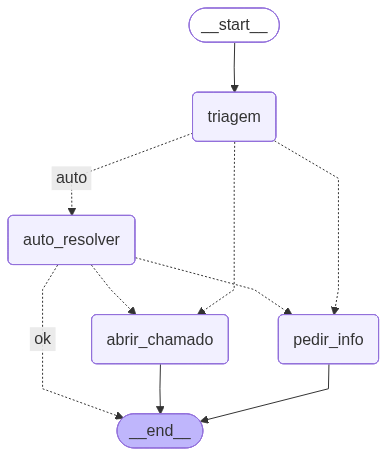

In [ ]:
from IPython.display import display, Image

graph_bytes = grafo.get_graph().draw_mermaid_png()
display(Image(graph_bytes))

LANGGRAPH